In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
from collections import Counter

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import balanced_accuracy_score, roc_curve, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from xgboost import plot_tree

from imblearn.combine import SMOTEENN


import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load the cleaned dataset
data = pd.read_csv('Processed_Telecom_Churn.csv')

# Display the first few rows to inspect the data
data.head()

,telecom_partner,gender,age,state,city,pincode,num_dependents,estimated_salary,calls_made,sms_sent,data_used,churn,tenure_days
0,0.666667,0.0,0.125000,0.370370,0.8,0.728604,1.00,0.807406,0.407407,0.849057,0.032845,0,1.0
1,0.666667,0.0,0.660714,0.592593,1.0,0.028771,0.50,0.850437,0.574074,0.735849,0.543445,0,1.0
2,1.000000,0.0,0.696429,0.037037,0.4,0.361032,0.00,0.990992,0.453704,0.452830,0.017560,1,1.0
3,0.333333,1.0,0.500000,0.814815,0.8,0.471475,0.25,0.144016,0.740741,0.471698,0.853153,1,1.0
4,0.333333,0.0,0.142857,0.888889,0.4,0.711644,0.50,0.269987,0.722222,0.283019,0.126740,0,1.0


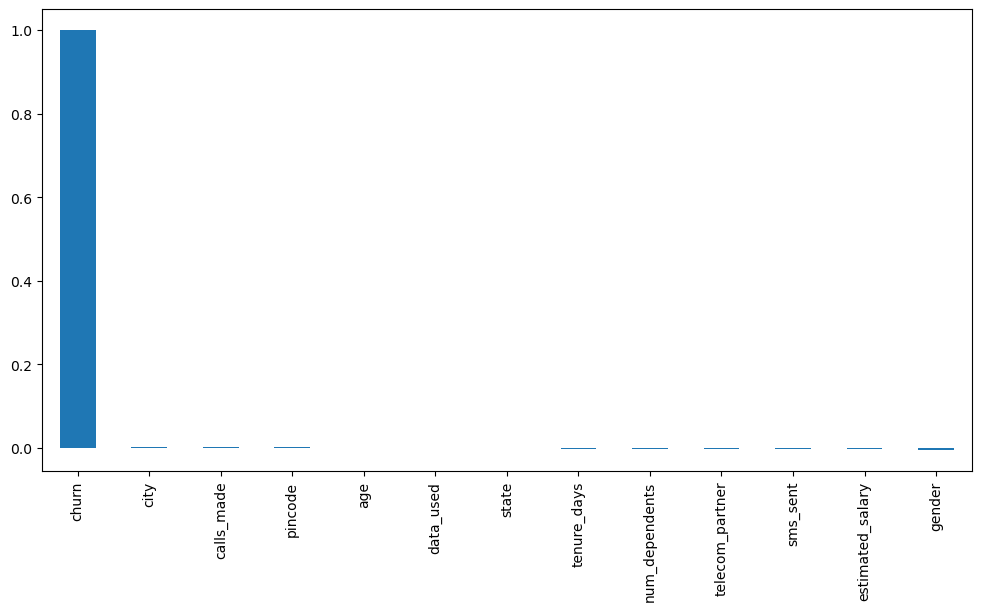

In [3]:
# Identify Top correlated features with Churn
plt.figure(figsize=(12,6))
data.corr()['churn'].sort_values(ascending=False).plot(kind='bar')
plt.show()

In [4]:
X = data.drop(columns=['churn'])
y = data['churn']
X.head()

,telecom_partner,gender,age,state,city,pincode,num_dependents,estimated_salary,calls_made,sms_sent,data_used,tenure_days
0,0.666667,0.0,0.125000,0.370370,0.8,0.728604,1.00,0.807406,0.407407,0.849057,0.032845,1.0
1,0.666667,0.0,0.660714,0.592593,1.0,0.028771,0.50,0.850437,0.574074,0.735849,0.543445,1.0
2,1.000000,0.0,0.696429,0.037037,0.4,0.361032,0.00,0.990992,0.453704,0.452830,0.017560,1.0
3,0.333333,1.0,0.500000,0.814815,0.8,0.471475,0.25,0.144016,0.740741,0.471698,0.853153,1.0
4,0.333333,0.0,0.142857,0.888889,0.4,0.711644,0.50,0.269987,0.722222,0.283019,0.126740,1.0


In [5]:
#Feature Selection using SelectKBest
from sklearn.feature_selection import SelectKBest

selection = SelectKBest(k=12)
X_select = selection.fit_transform(X,y)
X = X[X.columns[selection.get_support()]]
print(len(X.columns))
list(X.columns)

12


['telecom_partner',
 'gender',
 'age',
 'state',
 'city',
 'pincode',
 'num_dependents',
 'estimated_salary',
 'calls_made',
 'sms_sent',
 'data_used',
 'tenure_days']

In [6]:
# SMOTEENN for oversampling the minority class
st = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = st.fit_resample(X, y)
print("The number of classes before fit:", Counter(y))
print("The number of classes after fit:", Counter(y_train_resampled))

The number of classes before fit: Counter({0: 194726, 1: 48827})
The number of classes after fit: Counter({1: 177815, 0: 74370})


In [7]:
# Perform stratified train-test split to maintain the class distribution
X_train, X_test, y_train, y_test = train_test_split(X_train_resampled, y_train_resampled, test_size=0.2, random_state=42, stratify=y_train_resampled)

In [8]:
#List to store models
models = []

In [9]:
# Function to evaluate models with precision, recall, F1 score, and ROC AUC
def eval_metrics(model, X_test, y_test):
    y_pred_model = model.predict(X_test)
    y_probabilities = model.predict_proba(X_test)[:, 1]
    
    # Print evaluation metrics
    print(f"Precision: {precision_score(y_test, y_pred_model)}")
    print(f"Recall: {recall_score(y_test, y_pred_model)}")
    print(f"F1 Score: {f1_score(y_test, y_pred_model)}")
    print(f"ROC AUC Score: {roc_auc_score(y_test, y_probabilities)}")
    
    # Confusion matrix
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    conf_mat = confusion_matrix(y_test, y_pred_model)
    sns.heatmap(conf_mat, annot=True, fmt="d")
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Values')
    plt.ylabel('True Values')

    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_probabilities)
    plt.subplot(122)
    plt.plot(fpr, tpr, color='darkorange', lw=1, label=f"AUC: {roc_auc_score(y_test, y_probabilities):.3f}")
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

Precision: 0.705097448301842
Recall: 1.0
F1 Score: 0.827046511627907
ROC AUC Score: 0.512265825726361


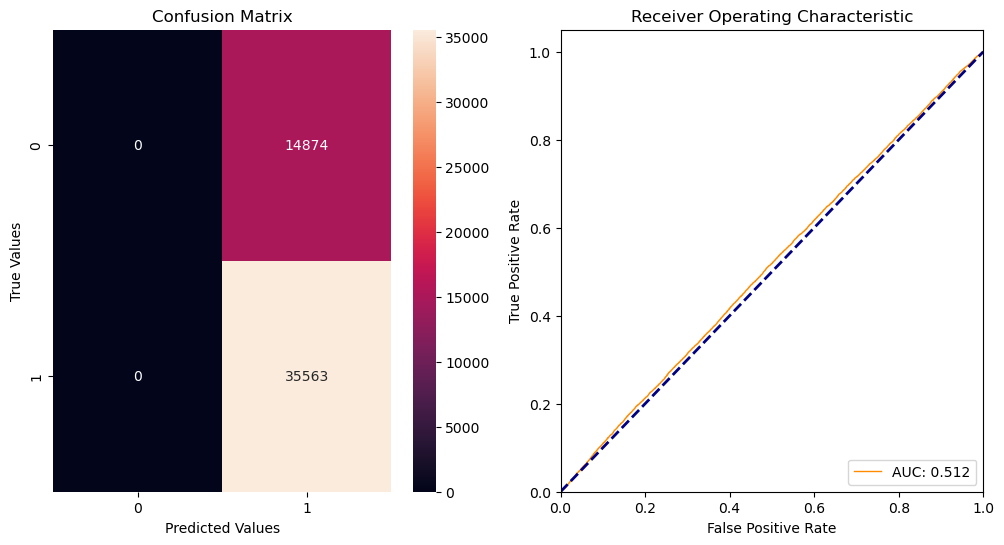

In [10]:
# Initialize and fit different models
# 1. Logistic Regression
churn_lr = LogisticRegression(random_state=42, max_iter=1000)
churn_lr.fit(X_train, y_train)
models.append(churn_lr)
eval_metrics(churn_lr, X_test, y_test)

Precision: 0.8512666165036368
Recall: 0.8589264122824284
F1 Score: 0.8550793606360048
ROC AUC Score: 0.7500561871819564


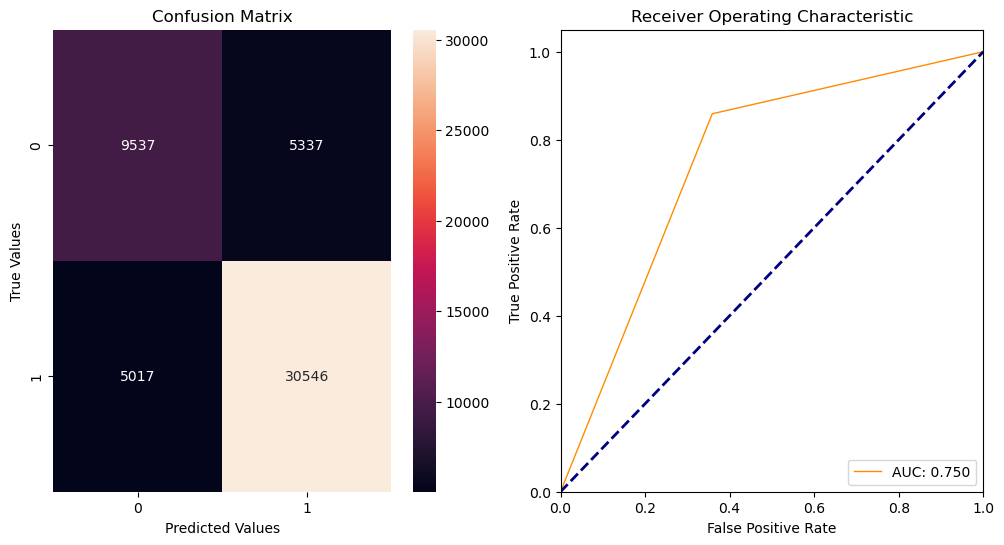

In [11]:
# 2. DecisionTreeClassifier
churn_DT = DecisionTreeClassifier(random_state=42)
churn_DT.fit(X_train, y_train)
models.append(churn_DT)
eval_metrics(churn_DT, X_test, y_test)

Precision: 0.705097448301842
Recall: 1.0
F1 Score: 0.827046511627907
ROC AUC Score: 0.5936108491241887


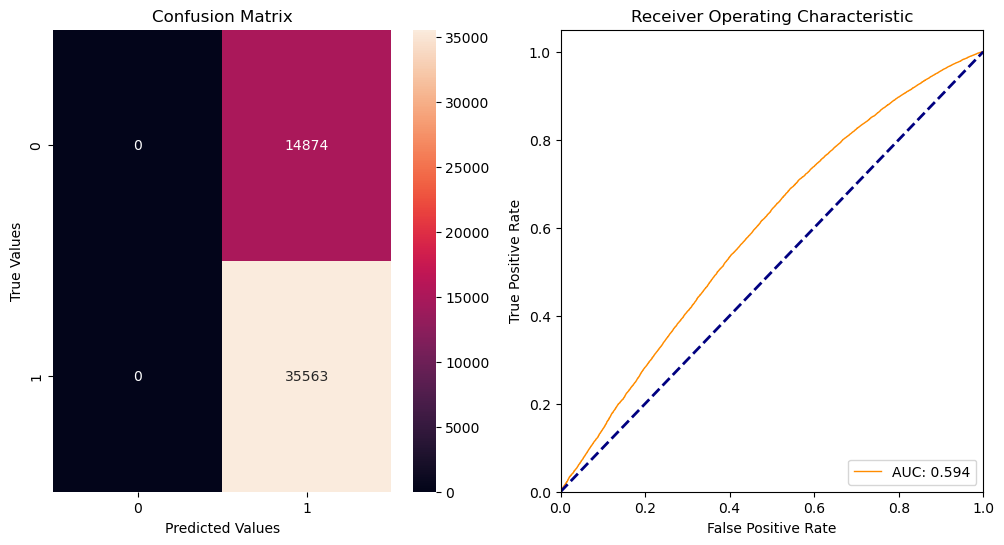

In [12]:
# 3. Gaussian Naive Bayes
churn_GNB = GaussianNB()
churn_GNB.fit(X_train, y_train)
models.append(churn_GNB)
eval_metrics(churn_GNB, X_test, y_test)

Precision: 0.8733374367757647
Recall: 0.9176391193093946
F1 Score: 0.8949403537638831
ROC AUC Score: 0.9330584097412652


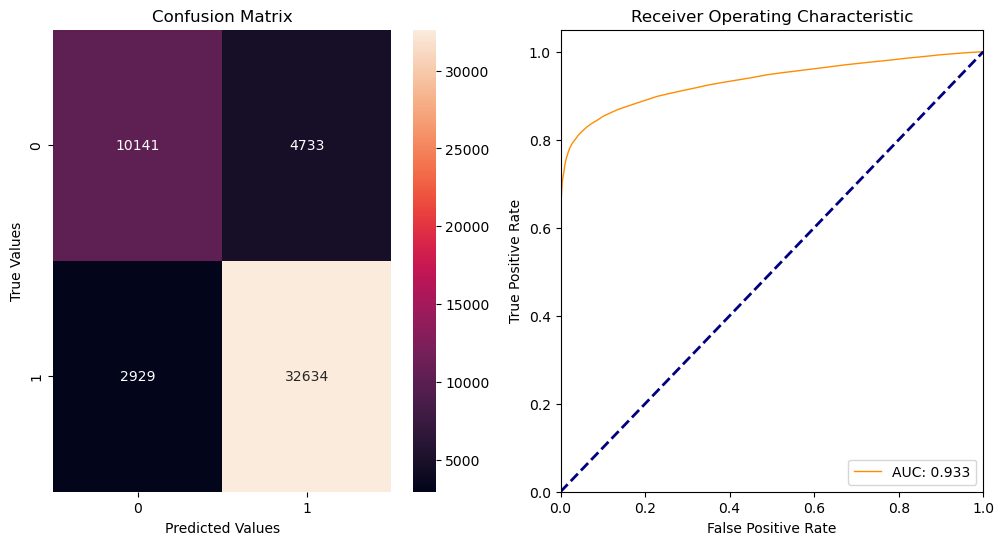

In [13]:
# 4. Random Forest
churn_rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
churn_rf.fit(X_train, y_train)
models.append(churn_rf)
eval_metrics(churn_rf, X_test, y_test)

Precision: 0.739507928300586
Recall: 0.9651885386497202
F1 Score: 0.8374095805023237
ROC AUC Score: 0.8519931142316433


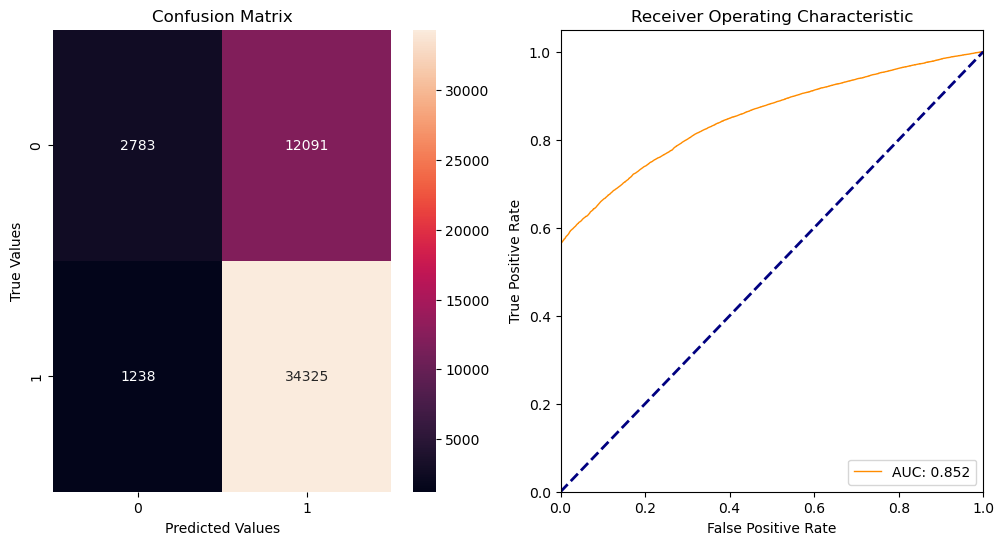

In [14]:
# 5. Gradient Boosting
churn_gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
churn_gb.fit(X_train, y_train)
models.append(churn_gb)
eval_metrics(churn_gb, X_test, y_test)

Precision: 0.9458717719802929
Recall: 0.8043753339144617
F1 Score: 0.8694040057137646
ROC AUC Score: 0.8990325943920174


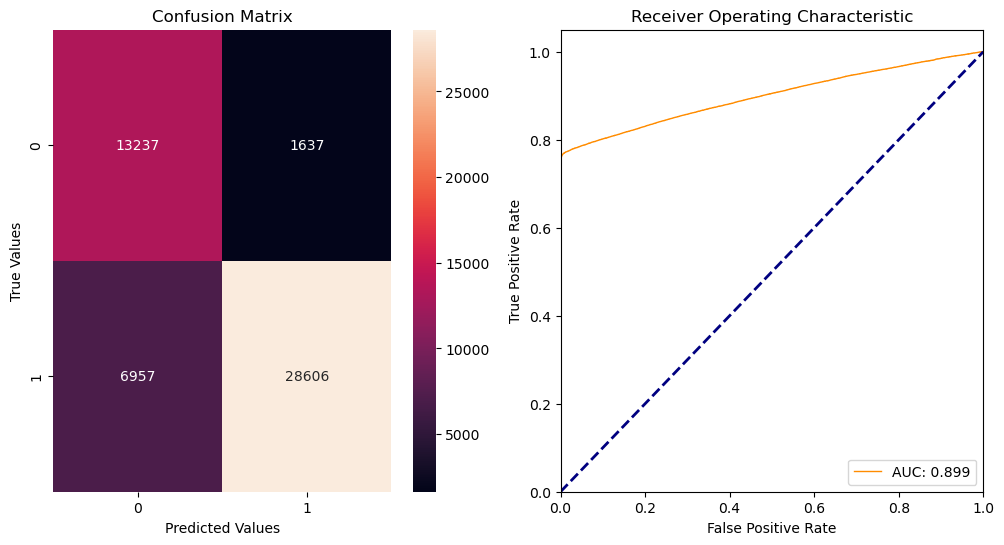

In [15]:
# 6. XGBoost
churn_xgb = XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1, use_label_encoder=False, eval_metric='logloss')
churn_xgb.fit(X_train, y_train)
models.append(churn_xgb)
eval_metrics(churn_xgb, X_test, y_test)

In [ ]:
from sklearn.model_selection import StratifiedKFold
# Model Comparison using K-Fold Cross Validation
result_col = ["Algorithm", "AUC Mean", "Bal Acc Mean", 'Recall']
model_results = pd.DataFrame(columns=result_col)

i = 0
for model in models:
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    cv_acc_results = cross_val_score(model, X_train, y_train,
                                     cv=skf, scoring="balanced_accuracy", n_jobs=-1)
    cv_auc_results = cross_val_score(model, X_train, y_train,
                                     cv=skf, scoring="roc_auc", n_jobs=-1)
    cv_recall_results = cross_val_score(model, X_train, y_train,
                                        cv=skf, scoring="recall", n_jobs=-1)

    model_results.loc[i] = [model.__class__.__name__,
                                    round(cv_auc_results.mean() * 100, 2),
                                    round(cv_acc_results.mean() * 100, 2),
                                    round(cv_recall_results.mean() * 100, 2),
                           ]
    i += 1

model_results = model_results.sort_values(by=['AUC Mean'], ascending=False)
print(model_results)

In [ ]:
# Sort results by AUC score
model_results = model_results.sort_values(by=['AUC Mean'], ascending=False)

# Plot model performance
plt.figure(figsize=(12, 6))
plt.plot(model_results['Algorithm'], model_results['AUC Mean'], marker='o', label='AUC Mean', color='b')
plt.plot(model_results['Algorithm'], model_results['Bal Acc Mean'], marker='o', label='Balanced Accuracy Mean', color='g')
plt.plot(model_results['Algorithm'], model_results['Recall'], marker='o', label='Recall', color='r')

plt.xticks(rotation=45)
plt.xlabel('Algorithms')
plt.ylabel('Score')
plt.title('Performance Metrics of Different Algorithms')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
# Define hyperparameter search space
rf_params_dist = {
    'n_estimators': [100, 300, 500],  
    'max_depth': [None, 10, 20, 30],  
    'max_features': ['sqrt', 'log2'], 
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf' : [1, 2, 4],
    'class_weight': ['balanced', 'balanced_subsample'],  
    'ccp_alpha': [0.0, 0.0005, 0.003]
}

# Initialize base model
churn_rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Perform Randomized Search with Cross-Validation
rf_random = RandomizedSearchCV(
    churn_rf, 
    rf_params_dist, 
    n_iter=20,
    scoring='roc_auc', 
    cv=3, 
    verbose=2,  
    n_jobs=-1,
    random_state=42
)

# Fit RandomizedSearchCV
rf_random.fit(X_train, y_train)

# Get best parameters
best_params = rf_random.best_params_
print("Best Parameters for RF:", best_params)
print("Best Score for RF:", rf_random.best_score_)


In [ ]:
# Train the optimized model
churn_rf_optimal = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    max_features=best_params['max_features'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    class_weight=best_params['class_weight'],
    ccp_alpha=best_params['ccp_alpha'],
    random_state=42,
    n_jobs=-1
)

# Fit the model on training data
churn_rf_optimal.fit(X_train, y_train)

In [ ]:
# Evaluate performance
print("Random Forest Model Evaluation:")
eval_metrics(churn_rf_optimal, X_test, y_test)

In [ ]:
# Feature importance visualization for Random Forest
importances = churn_rf_optimal.feature_importances_
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': importances})
feature_importances = feature_importances.sort_values(by='importance', ascending=True)

plt.figure(figsize=(12, 6))
plt.barh(feature_importances['feature'], feature_importances['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances for Random Forest')
plt.show()

In [ ]:
# Define hyperparameter search space
xgb_params_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1], 
    'max_depth': [3, 5, 7],  
    'gamma': [0, 0.25, 0.5, 1], 
    'reg_lambda': [1, 5, 10],  
    'scale_pos_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Initialize base model
churn_xgb = XGBClassifier(random_state=42, n_jobs=-1, use_label_encoder=False, eval_metric="logloss")

# Perform Randomized Search
xgb_random = RandomizedSearchCV(
    churn_xgb,
    xgb_params_dist,
    scoring='roc_auc',
    cv=3,
    n_iter=20,  # Randomly search 20 combinations
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Fit RandomizedSearchCV
xgb_random.fit(X_train, y_train)

# Get best parameters
best_params = xgb_random.best_params_
print("Best Parameters for XGBoost:", best_params)
print("Best Score for XGBoost:", xgb_random.best_score_)


In [ ]:
# Train the optimized model
churn_xgb_optimal = XGBClassifier(
    n_estimators=best_params['n_estimator'],
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    gamma=best_params['gamma'],
    reg_lambda=best_params['reg_lambda'],
    scale_pos_weight=best_params['scale_pos_weight'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    random_state=42,
    n_jobs=-1,
    use_label_encoder=False,
    eval_metric="logloss"
)

# Fit the model on training data
churn_xgb_optimal.fit(X_train, y_train,
                    eval_set=[(X_test, y_test)],
                     eval_metric=['aucpr', 'roc_auc'],
                     early_stopping_rounds=10,
                     verbose=False)

In [ ]:
# Evaluate performance
print("XGBoost Model Evaluation:")
eval_metrics(churn_xgb_optimal, X_test, y_test)

In [ ]:
# Feature importance visualization for XGBoost
importances = churn_xgb_optimal.feature_importances_
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': importances})
feature_importances = feature_importances.sort_values(by='importance', ascending=True)

plt.figure(figsize=(12, 6))
plt.barh(feature_importances['feature'], feature_importances['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances for XGBoost')
plt.show()

In [ ]:
import pickle

# Save the final XGBoost model to disk
pickle.dump(churn_xgb_optimal, open('churn_xgb_optimal.pkl', 'wb'))

In [ ]:
# Save the final XGBoost model to disk
pickle.dump(churn_rf_optimal, open('churn_rf_optimal.pkl', 'wb'))